# Introduction

In this notebook we use Google's Tensorflow library to classify the clarity of the diamonds knowing its other characteristics.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.models import Model

from scipy import stats

## The data

### Getting the data

Reading the dataset into a Pandas Dataframe Object

In [118]:
data = pd.read_csv("diamonds.csv")

In [119]:
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### Cleaning the data
The dataset has no null values as seen:

In [120]:
data.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

The `color` and `cut` and `clarity` columns are categorical, not numeric. So the next step is to one-hot encode the values in the columns with `pd.get_dummies`.

In [121]:
data = pd.get_dummies(data, columns=['color'], prefix='color')
data = pd.get_dummies(data, columns=['cut'], prefix='cut')
data.head()

,carat,clarity,depth,table,price,x,y,z,color_D,color_E,color_F,color_G,color_H,color_I,color_J,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good
0,0.23,SI2,61.5,55.0,326,3.95,3.98,2.43,0,1,0,0,0,0,0,0,0,1,0,0
1,0.21,SI1,59.8,61.0,326,3.89,3.84,2.31,0,1,0,0,0,0,0,0,0,0,1,0
2,0.23,VS1,56.9,65.0,327,4.05,4.07,2.31,0,1,0,0,0,0,0,0,1,0,0,0
3,0.29,VS2,62.4,58.0,334,4.20,4.23,2.63,0,0,0,0,0,1,0,0,0,0,1,0
4,0.31,SI2,63.3,58.0,335,4.34,4.35,2.75,0,0,0,0,0,0,1,0,1,0,0,0


In [152]:
clarity_labels = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

In [122]:
data.replace(['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1'],
             [7, 6, 5, 4, 3, 2, 1, 0], inplace=True)
data.head()

,carat,clarity,depth,table,price,x,y,z,color_D,color_E,color_F,color_G,color_H,color_I,color_J,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good
0,0.23,1,61.5,55.0,326,3.95,3.98,2.43,0,1,0,0,0,0,0,0,0,1,0,0
1,0.21,2,59.8,61.0,326,3.89,3.84,2.31,0,1,0,0,0,0,0,0,0,0,1,0
2,0.23,4,56.9,65.0,327,4.05,4.07,2.31,0,1,0,0,0,0,0,0,1,0,0,0
3,0.29,3,62.4,58.0,334,4.20,4.23,2.63,0,0,0,0,0,1,0,0,0,0,1,0
4,0.31,1,63.3,58.0,335,4.34,4.35,2.75,0,0,0,0,0,0,1,0,1,0,0,0


Remove outliers that have z score higher than 3 or lower than -3 

In [123]:
data = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]


In [124]:
data.shape

(43898, 20)

### Split the data into training and test sets
Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of the model.

In [125]:
train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)


In [126]:
train_dataset.shape

(35118, 20)

### Split features from labels
Separate the target value —the clarity, also called the label— from the features. This label is the value that we will train the model to classify.

In [127]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('clarity')
test_labels = test_features.pop('clarity')


In [128]:
train_features.shape

(35118, 19)

## Normalization
In the table of statistics it's easy to see how different the ranges of each feature are:

In [129]:
train_dataset[['carat', 'depth', 'table', 'price', 'x', 'y', 'z']].describe().transpose()[['mean', 'std']]

,mean,std
carat,0.731307,0.411764
depth,61.610507,1.062151
table,57.234395,1.996659
price,3498.515092,3437.424130
x,5.594549,1.045153
y,5.598036,1.037866
z,3.447391,0.641583


It is good practice to normalize features that have different ranges.

If we skip normalizing the features, the model will still converge (ie: reach the optimum loss. ie: become able to predict and perform regression as best as it can), However, normalization makes training much more stable.

### The Normalization layer
The tf.keras.layers.Normalization is a clean and simple way to add feature normalization into owr model.

The first step is to create the layer:

In [130]:
normalizer = tf.keras.layers.Normalization(axis=-1)


Then, fit the state of the preprocessing layer to the data by calling Normalization.adapt:

In [131]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [132]:
print(normalizer.mean.numpy())

[[   0.731   61.611   57.234 3498.516    5.595    5.598    3.447    0.132
     0.193    0.188    0.225    0.161    0.101    0.       0.       0.
     0.465    0.283    0.252]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [133]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())


First example: [[  0.26  62.3   57.   599.     4.06   4.09   2.54   0.     1.     0.
    0.     0.     0.     0.     0.     0.     1.     0.     0.  ]]

Normalized: [[-1.14  0.65 -0.12 -0.84 -1.47 -1.45 -1.41 -0.39  2.04 -0.48 -0.54 -0.44
  -0.34  0.    0.    0.    1.07 -0.63 -0.58]]


In [137]:
model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(8)
])


In [138]:
model.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])


In [139]:
r = model.fit(train_features, train_labels, validation_data=(test_features, test_labels), epochs=100)


Epoch 1/100
1098/1098 [==============================] - 4s 3ms/step - loss: 1.4492 - accuracy: 0.3971 - val_loss: 1.2262 - val_accuracy: 0.4589
Epoch 2/100
1098/1098 [==============================] - 3s 3ms/step - loss: 1.1657 - accuracy: 0.5051 - val_loss: 1.1278 - val_accuracy: 0.5172
Epoch 3/100
1098/1098 [==============================] - 3s 3ms/step - loss: 1.1082 - accuracy: 0.5273 - val_loss: 1.1292 - val_accuracy: 0.4967
Epoch 4/100
1098/1098 [==============================] - 3s 3ms/step - loss: 1.0767 - accuracy: 0.5412 - val_loss: 1.0620 - val_accuracy: 0.5361
Epoch 5/100
1098/1098 [==============================] - 3s 3ms/step - loss: 1.0553 - accuracy: 0.5495 - val_loss: 1.0536 - val_accuracy: 0.5461
Epoch 6/100
1098/1098 [==============================] - 4s 3ms/step - loss: 1.0364 - accuracy: 0.5577 - val_loss: 1.1299 - val_accuracy: 0.5202
Epoch 7/100
1098/1098 [==============================] - 4s 4ms/step - loss: 1.0196 - accuracy: 0.5682 - val_loss: 1.0105 - val_ac

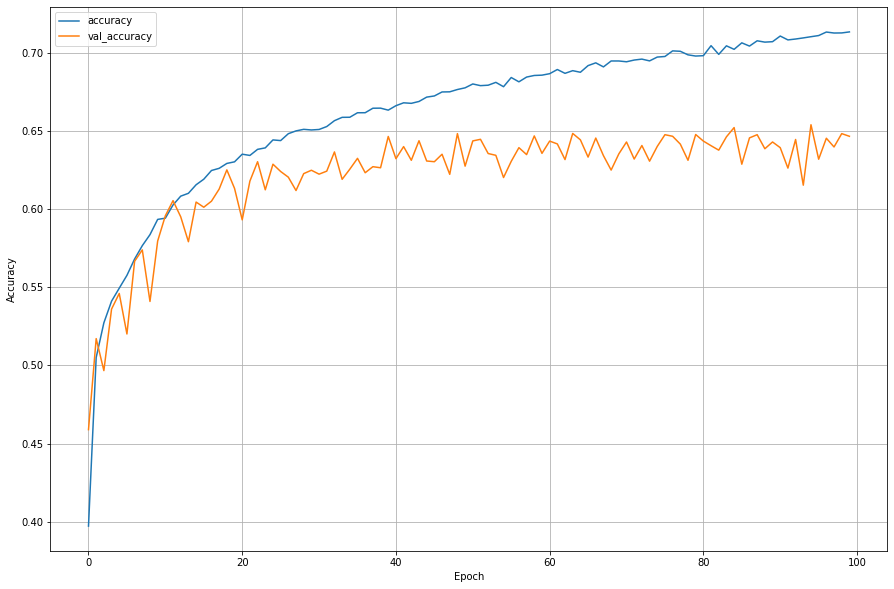

In [141]:
def plot_loss(history):
    plt.figure(figsize=(15, 10))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_loss(r)

## Make predictions
With the model trained, we now use it to make predictions about the clarity of diamonds. We attach a softmax layer to convert the model's output to probabilities, which are easier to interpret.

In [142]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])


We let the model predict the clarity of the test set:

In [143]:
predictions = probability_model.predict(test_features)


We take a look at the first prediction:

In [144]:
predictions[0]


array([0.   , 0.   , 0.003, 0.121, 0.015, 0.652, 0.209, 0.   ],
      dtype=float32)

The prediction is an array of 8 numbers. They represent the model's "confidence" that the clarity corresponds to each of the 8 different clarity classes. To see which label has the highest confidence value:

In [145]:
np.argmax(predictions[0])


5

In [153]:
clarity_labels[np.argmax(predictions[0])]


'VVS2'

## Review Performance

To get an overview of the model's performance, we print the confusion matrix of the predicted labels. This shows us how many labels did the model classify correctly and how many did he miss.

In [192]:

predicted = np.argmax(predictions, axis=1)
predicted.shape

confusion_matrix = pd.crosstab(test_labels, predicted, rownames=[
                               'Actual'], colnames=['Predicted'])
print(confusion_matrix)


Predicted   0     1     2     3    4    5    6    7
Actual                                             
0          51    24     1     0    0    0    0    0
1          18  1107   306     7    1    1    0    0
2           0   243  1489   196   46   10    6    0
3           0    25   403  1293  280   51   12    3
4           0     8    84   355  697  126   31    4
5           0     0     6    55  204  524   95   17
6           0     0     1    15   38  216  340   56
7           0     0     0     1    7   41  108  178


Now let's visualise the confusion matrix:

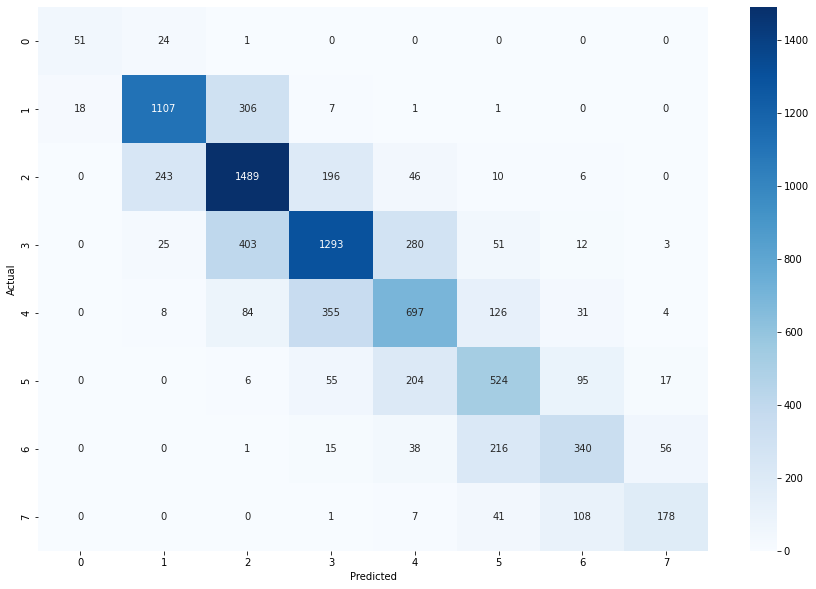

In [203]:

confusion_matrix = pd.crosstab(test_labels, predicted, rownames=[
                               'Actual'], colnames=['Predicted'])

plt.figure(figsize=(15, 10))
plt.ticklabel_format(style='plain')
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()


## Conclusion

We built a classifying deep learning model to classify the clarity of the diamonds using TensorFlow library. The model reached top accuracy of 65%, this is quite low because diamond clarity only has moderate to weak correlations with the other diamond attributes. In the end we visualised the model's performance using the confusion matrix.